<a href="https://colab.research.google.com/github/augustinechang1/reinforcement-learning-stock-trade/blob/master/qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random


https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/5.q-learning-agent.ipynb

In [0]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [18]:
!pip install alpha_vantage

  Stored in directory: /root/.cache/pip/wheels/21/9c/02/b7cfae63f7119f4089f229ba1a09ce90fabbaf96199c2890be
Successfully built alpha-vantage


In [22]:
ts = TimeSeries(key='X5AYBIDIH2EVGNW9', output_format='pandas')
stock, meta_data = ts.get_daily(symbol='DJIA', outputsize='full')
stock = stock['4. close']
df = pd.DataFrame({'Date':stock.index, 'Close':stock.values})
df.head()

,Date,Close
0,2000-01-03,11357.5098
1,2000-01-04,10997.9297
2,2000-01-05,11122.6504
3,2000-01-06,11253.2598
4,2000-01-07,11522.5596


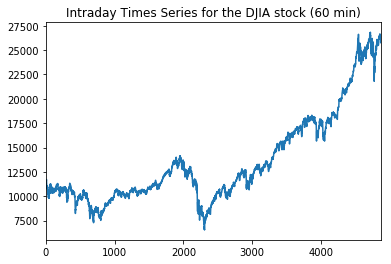

In [0]:
df['Close'].plot()
plt.title('Intraday Times Series for the DJIA stock (60 min)')
plt.show()

In [0]:
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 7193.969800.3, cost: nan, total money: 17193.969800
epoch: 20, total rewards: 3093.379900.3, cost: nan, total money: 13093.379900
epoch: 30, total rewards: 16286.192000.3, cost: nan, total money: 26286.192000
epoch: 40, total rewards: 1574.209900.3, cost: nan, total money: 11574.209900
epoch: 50, total rewards: 2769.780200.3, cost: nan, total money: 12769.780200
epoch: 60, total rewards: 6978.298800.3, cost: nan, total money: 16978.298800
epoch: 70, total rewards: -2354.419900.3, cost: nan, total money: 7645.580100
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 10000.000000
epoch: 90, total rewards: 9093.450600.3, cost: nan, total money: 19093.450600
epoch: 100, total rewards: 1449.969200.3, cost: nan, total money: 11449.969200
epoch: 110, total rewards: 5468.619100.3, cost: nan, total money: 15468.619100
epoch: 120, total rewards: 12532.031200.3, cost: nan, total money: 22532.031200
epoch: 130, total rewards: -454.819400.3, cost: nan, total mon

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 442: buy 1 unit at price 9052.440400, total balance 947.559600
day 1220, sell 1 unit at price 10385.480500, investment 14.725754 %, total balance 11333.040100,
day 1237: buy 1 unit at price 10547.059600, total balance 785.980500
day 1281, sell 1 unit at price 10724.629900, investment 1.683600 %, total balance 11510.610400,
day 1327: buy 1 unit at price 10087.509800, total balance 1423.100600
day 1637, sell 1 unit at price 11103.549800, investment 10.072258 %, total balance 12526.650400,
day 1686: buy 1 unit at price 11555.000000, total balance 971.650400
day 1897, sell 1 unit at price 13943.419900, investment 20.670012 %, total balance 14915.070300,
day 2093: buy 1 unit at price 13010.000000, total balance 1905.070300
day 2794, sell 1 unit at price 12229.290000, investment -6.000846 %, total balance 14134.360300,
day 2801: buy 1 unit at price 12212.790000, total balance 1921.570300
day 2965, sell 1 unit at price 11644.490200, investment -4.653317 %, total balance 13566.060500,
day 

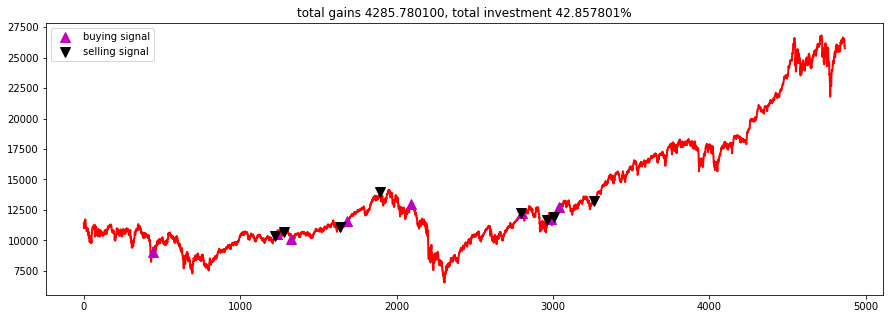

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [0]:
class Agent:
  
  def __init__(self, state_size, trend):
    self.state_size = state_size # previous days
    self.action_size = 3 # hold, buy, sell
    self.memory = deque(maxlen=1000)
    self.window_size = window_size
    self.half_window = window_size // 2
    self.batch_size = 32
    self.skip = 1
    self.trend = trend
    
    self.gamma = 0.95 # discount rate
    self.epsilon = 1.0 # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.999
    self.model = self._model()
    
  def _model(self):
    model = Sequential()
    model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(self.action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))

    return model
  
  # returns an an n-day state representation ending at time t
  def get_state(self, t):
    window_size = self.window_size + 1
    d = t - window_size + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(window_size - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size) #exploration
    
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # exploitation
  
  def replay(self, batch_size):
    mini_batch = []
    l = len(self.memory)
    for i in range(l - batch_size + 1, l):
      mini_batch.append(self.memory[i])

    for state, action, reward, next_state, done in mini_batch:

      # Q(s', a)
      target = reward
      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

      # Q(s, a)
      target_f = self.model.predict(state)
      target_f[0][action] = target
      self.model.fit(state, target_f, epochs=1, verbose=0)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
  
  
  def train(self, iterations, checkpoint, initial_money):
    for e in range(iterations):
#       print ("Episode " + str(e) + "/" + str(episode_count))
      state = self.get_state(0)
      starting_money = initial_money
      total_profit = 0
      Agent.inventory = []
      l = len(data) - 1
      
      for t in range(0, len(self.trend) - 1):
        action = agent.act(state)

        # sit
        next_state = self.get_state(t+1)
        reward = 0

        if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window): # buy
          Agent.inventory.append(data[t])
          starting_money -= self.trend[t]
          print ("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
          bought_price = Agent.inventory.pop(0)
          reward = max(data[t] - bought_price, 0)
          total_profit += data[t] - bought_price
          starting_money += self.trend[t]
          print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        self.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
          print ("--------------------------------")
          print ("Total Profit: " + formatPrice(total_profit))
          print ("--------------------------------")

        if len(agent.memory) > self.batch_size:
          self.replay(self.batch_size)

      if e % 10 == 0:
        agent.model.save("model_ep" + str(e))

  

In [64]:
data = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size ,trend = data)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Buy: $9862.12
Sell: $10367.20 | Profit: $505.08
Buy: $10170.50
Sell: $10131.41 | Profit: -$39.09
Buy: $10412.49
Sell: $10603.63 | Profit: $191.14
Buy: $10527.13
Sell: $10522.33 | Profit: -$4.80
Buy: $10564.21
Sell: $10435.16 | Profit: -$129.05
Buy: $10447.89
Sell: $10560.67 | Profit: $112.78
Buy: $10586.13
Sell: $10521.98 | Profit: -$64.15
Buy: $10568.43
Sell: $10413.79 | Profit: -$154.64
Buy: $10192.18
Sell: $10238.80 | Profit: $46.62
Buy: $10226.59
Sell: $10271.72 | Profit: $45.13
Buy: $10393.07
Sell: $10326.48 | Profit: -$66.59
Buy: $10380.12
Sell: $10971.14 | Profit: $591.02
Buy: $10907.06
Sell: $10834.25 | Profit: -$72.81
Buy: $10681.06
Sell: $10707.60 | Profit: $26.54
Buy: $10656.03
Sell: $10470.23 | Profit: -$185.80
Buy: $10629.11
Sell: $10414.49 | Profit: -$214.62
Buy: $10434.96
Sell: $10645.42 | Profit: $210.46
Buy: $10635.56
Sell: $10945.75 | Profit: $310.19
Buy: $10912.41
Sell: $10662.01 | Profit: -$250.40
Buy: $10572.55
Sell: $10652.66 | Profit: $80.11
Buy: $10702.19
Sell: 

KeyboardInterrupt: ignored